In [1]:
import capstone_utils as cu
%matplotlib inline

---

In [2]:
myticker = 'GME'
df = cu.create_ticker_df(myticker)

In [3]:
y_train, y_test = cu.train_test_split_arima(df)

In [4]:
cu.interpret_dftest(cu.adfuller(y_train))

Test Statistic   -4.261247
p-value           0.000518
dtype: float64

In [5]:
best_arima_order = cu.find_best_aic(y_train)

MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(4,1,1).
This model has an AIC of -1493.9634355760768.


In [6]:
model = cu.ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
              order = best_arima_order)

# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = model.predict(params = arima.params)
preds_cuttoff = preds.shape[0]-64
preds= preds[preds_cuttoff:]

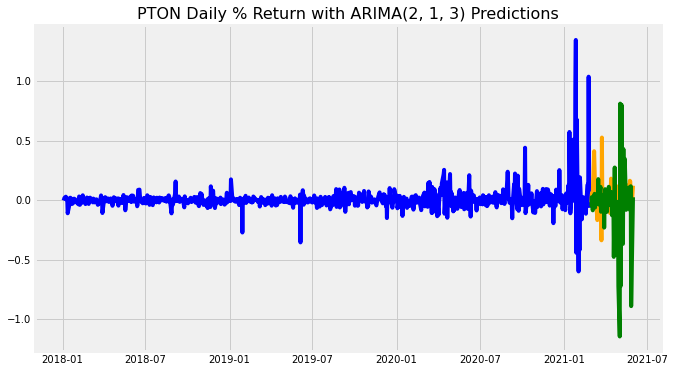

In [7]:
cu.plt.figure(figsize=(10,6))
# Plot training data.
cu.plt.plot(y_train.index, cu.pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
cu.plt.plot(y_test.index, cu.pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
cu.plt.plot(y_test.index, preds, color = 'green')

cu.plt.title(label = 'PTON Daily % Return with ARIMA(2, 1, 3) Predictions', fontsize=16)
cu.plt.show();

In [8]:
start =df.iloc[-65]['adjusted_close']

In [9]:
predicted_adj_close = cu.make_predicted_adj_close_df(start, preds)

close_train = df[df.index < cu.datetime(year = 2021, month = 3, day = 1)]
close_test = df[df.index > cu.datetime(year = 2021, month = 3, day = 1)]
close_train = close_train['adjusted_close']
close_test = close_test['adjusted_close'] 
close_train = cu.pd.DataFrame(close_train)
close_test = cu.pd.DataFrame(close_test)

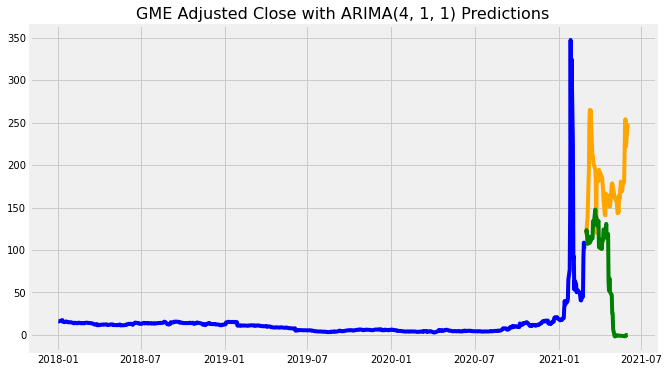

In [10]:
cu.plt.figure(figsize=(10,6))

# Plot training data.
cu.plt.plot(close_train.index, cu.pd.DataFrame(close_train), color = 'blue')

# Plot testing data.
cu.plt.plot(close_test.index, cu.pd.DataFrame(close_test), color = 'orange')

# Plot predicted test values.
cu.plt.plot(close_test.index, predicted_adj_close, color = 'green')

cu.plt.title(label = f'{myticker} Adjusted Close with ARIMA{best_arima_order} Predictions', fontsize=16)
cu.plt.show();

In [11]:
gt_train = df[df.index < cu.datetime(year = 2021, month = 3, day = 1)]
gt_train['diff_trend_score']= gt_train['trend_score'].diff(1)

gt_train = gt_train['diff_trend_score']

endog = y_train.astype(float).dropna()
exog = cu.sm.add_constant(gt_train.astype(float).dropna())

In [12]:
mod = cu.sm.tsa.statespace.SARIMAX(endog, exog, order=best_arima_order, trend = 't')
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:       daily_pct_return   No. Observations:                  793
Model:               SARIMAX(4, 1, 1)   Log Likelihood                 684.095
Date:                Thu, 15 Jul 2021   AIC                          -1350.190
Time:                        14:13:49   BIC                          -1308.119
Sample:                             0   HQIC                         -1334.021
                                - 793                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
drift             9.554e-07   4.82e-06      0.198      0.843   -8.49e-06    1.04e-05
const             4.508e-20   1.96e-10    2.3e-10      1.000   -3.84e-10    3.84e-10
diff_trend_score    -0.0026 

In [13]:
preds_with_gt = res.predict()
preds_with_gt = preds_with_gt[preds_cuttoff:]

In [14]:
predicted_adj_close = cu.make_predicted_adj_close_df(start, preds_with_gt)
predicted_adj_close = predicted_adj_close[1:]

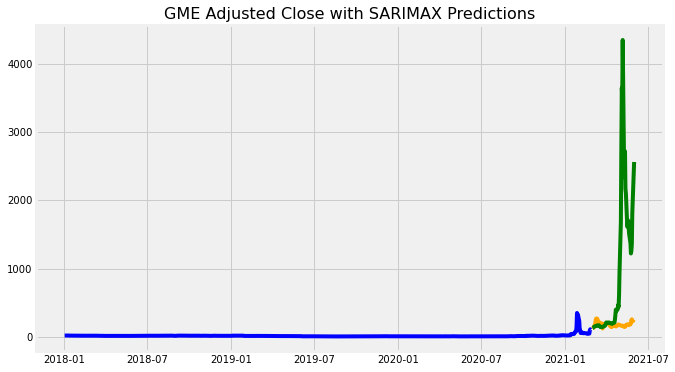

In [15]:
cu.plt.figure(figsize=(10,6))

# Plot training data.
cu.plt.plot(close_train.index, cu.pd.DataFrame(close_train), color = 'blue')

# Plot testing data.
cu.plt.plot(close_test.index, cu.pd.DataFrame(close_test), color = 'orange')

# Plot predicted test values.
cu.plt.plot(close_test.index, predicted_adj_close, color = 'green')

cu.plt.title(label = f'{myticker} Adjusted Close with SARIMAX Predictions', fontsize=16)
cu.plt.show();

In [16]:
test = 'ssr_chi2test'
cu.grangers_causation_matrix(df, variables = ['adjusted_close', 'trend_score'])

,adjusted_close_x,trend_score_x
adjusted_close_y,1.0,0.0
trend_score_y,0.0,1.0


In [17]:
df['trend_score_diff'] = df['trend_score'].diff(1)

df = df[['adjusted_close', 'trend_score']]

#train_test_split
nobs = 30
df_train, df_test = df[0:-nobs], df[-nobs:]

df_differenced = df_train.diff().dropna()

model = cu.VAR(df_differenced)

In [18]:
lowest = 100_000
for i in [1,2,3,4,5,6,7,8,9]:
    #print(i)
    result = model.fit(i)
    #print('Lag Order =', i)
    #print('AIC : ', result.aic)
    if result.aic < lowest:
        lowest = result.aic
        best_lag = i


print(f'best lag: {best_lag}')
print(f'best AIC: {lowest}')

best lag: 9
best AIC: 6.472035009526216


In [19]:
var = model.fit(best_lag)

In [20]:
var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 15, Jul, 2021
Time:                     14:13:50
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    6.69048
Nobs:                     819.000    HQIC:                   6.55586
Log likelihood:          -4936.52    FPE:                    646.809
AIC:                      6.47204    Det(Omega_mle):         617.812
--------------------------------------------------------------------
Results for equation adjusted_close
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.223944         0.237606            0.943           0.346
L1.adjusted_close        -0.254155         0.035019           -7.258           0.000
L1.trend_score            0.730081 

In [21]:
forecast_input = df_differenced.values[-best_lag:]

fc = var.forecast(y=forecast_input, steps=nobs)
df_forecast = cu.pd.DataFrame(fc, index=df_test.index[-nobs:], columns=df_train.columns + '_2d')

df_results = cu.invert_transformation(df_train, df_forecast, second_diff=True)

In [22]:
predicted_adj_close = df_results['adjusted_close_forecast']

close_test = df_test[df_test.index > cu.datetime(year = 2021, month = 3, day = 1)]

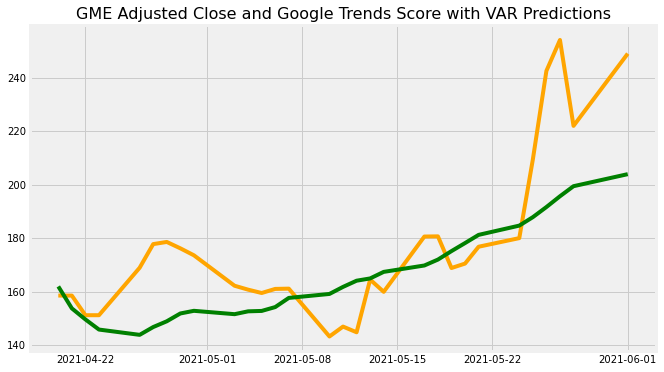

In [23]:
cu.plt.figure(figsize=(10,6))

# Plot testing data.
cu.plt.plot(close_test.index, cu.pd.DataFrame(close_test)['adjusted_close'], color = 'orange')

# Plot predicted test values.
cu.plt.plot(predicted_adj_close.index, predicted_adj_close, color = 'green')

cu.plt.title(label = f'{myticker} Adjusted Close and Google Trends Score with VAR Predictions', fontsize=16)
cu.plt.show();

In [24]:
close_train = df[df.index < cu.datetime(year = 2021, month = 4, day = 21)]
close_train = close_train['adjusted_close']
close_train = cu.pd.DataFrame(close_train)
close_test = cu.pd.DataFrame(close_test)

In [25]:
predicted_adj_close = df_results['adjusted_close_forecast']

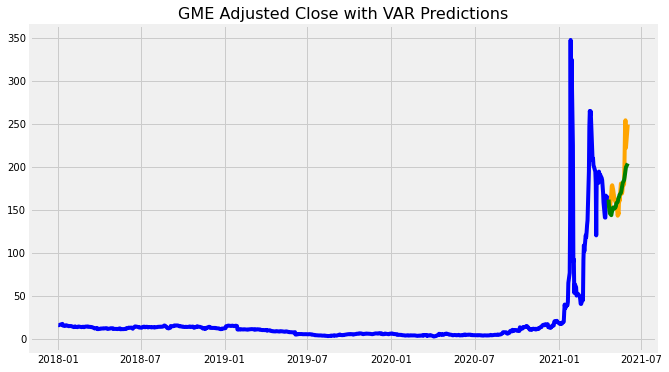

In [26]:
cu.plt.figure(figsize=(10,6))

# Plot training data.
cu.plt.plot(close_train.index, cu.pd.DataFrame(close_train), color = 'blue')
# Plot training data.

# Plot testing data.
cu.plt.plot(close_test.index, cu.pd.DataFrame(close_test)['adjusted_close'], color = 'orange')

# Plot predicted test values.
cu.plt.plot(close_test.index, predicted_adj_close, color = 'green')

cu.plt.title(label = f'{myticker} Adjusted Close with VAR Predictions', fontsize=16)
cu.plt.show();